In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 

import prediction_pipeline as dff

import warnings
warnings.filterwarnings("ignore")

#working from py file results in error due to tsfresh extract_features so we make pipeline in notebook
#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

plt.rcParams['font.size'] = 8 

# Create sample data

We use particular EIC load data, temp and price data

In [2]:
def img(data,save=False):
    d = data.copy(deep=True).reset_index().rename(columns={'index':'TIME',data.columns[0]:'AMOUNT'})
    moment = pd.DatetimeIndex(d['TIME'])[-1]
    pastLags = d.shape[0]
    if d['TIME'].dt.hour.values[0] != 0:
        dataFirstHour = d['TIME'].dt.hour.values[0]
        dataFirstDate = d['TIME'].dt.date.values[0]
        fillingData = pd.DataFrame()
        fillingData['TIME'] = pd.date_range(dataFirstDate, periods=dataFirstHour, freq='1H')
        fillingData['AMOUNT'] = 0.0
        data = pd.concat([fillingData,data])

    if d['TIME'].dt.hour.values[-1] != 23:
        fillingData = pd.DataFrame()
        dataLastDate = d['TIME'].values[-1] + np.timedelta64(1,'h')  #add 1 hour since date_range starts from zero index
        dataLastHour = d['TIME'].dt.hour.values[-1]
        fillingData['TIME'] = pd.date_range(dataLastDate, periods=23-dataLastHour, freq='1H')
        fillingData['AMOUNT'] = 0.0
        data = pd.concat([data,fillingData])

    amount = d['AMOUNT'].values.reshape((d.shape[0]//24,24)).T
    months = d['TIME'].dt.month.values.reshape((d.shape[0]//24,24)).T[0] #month as a row
    monthsCount = np.bincount(months)[1:]
    monthsTicks = [np.sum(monthsCount[:i]) for i in range(1,13)]
    monthsTicks = [0]+monthsTicks    
    fig = plt.figure(figsize=(20,4))
    ax = plt.axes()
    im = plt.imshow(amount,cmap='binary')
    for i in range(len(monthsTicks)-1):
        col = 'r' 
        if i%2==1: col = 'b' 
        plt.plot([monthsTicks[i],monthsTicks[i+1]],[-1,-1],lw=4,c=col)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.suptitle(f'from {moment} and {pastLags//24} days back')
    ax.grid(False)
    plt.show()
    if save==True: plt.savefig('img_consumptionImage.png');

def eicData(eic,data,verbose=False,save=False):
    EICdata = data[data['EIC']==eic].drop(columns=['EIC'])
    EICdata = EICdata.drop_duplicates(subset='TIME') #drop duplicated timestamps
    EICdata['TIME'] = pd.DatetimeIndex(EICdata['TIME']) #we need to convert to DateTimeFormat to sort
    EICdata = EICdata.sort_values(by='TIME',ascending=True)
    EICdata = EICdata.set_index('TIME').rename_axis(None)
#    EICdata['id'] = 1
    if verbose==True: img(EICdata,save=save)
    return EICdata


In [3]:
#prepared data for year 2021
randomState = 2023

eicdata = pd.read_csv('eicdata.csv')
eicdata['time'] = pd.DatetimeIndex(eicdata['time'])
eicdata = eicdata.set_index('time').rename_axis(None).sort_index()


temp = pd.read_csv('temp.csv') #temp in in K
temp['time'] = pd.DatetimeIndex(temp['time'])
temp = temp.set_index('time').rename_axis(None).sort_index()

price = pd.read_csv('price.csv') #Eur/MWh
price['time'] = pd.DatetimeIndex(price['time'])
price = price.set_index('time').rename_axis(None).sort_index()/1000 #Eur/kWh

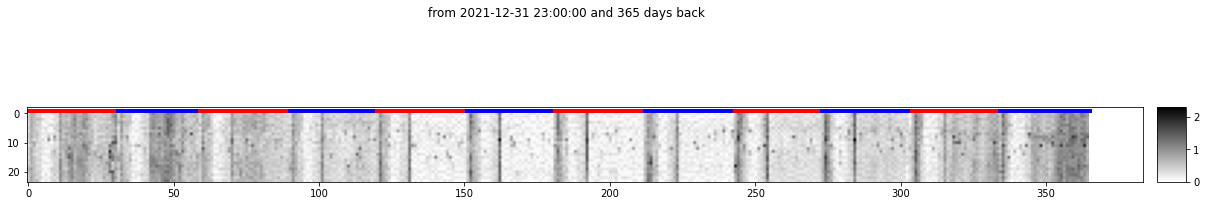

In [4]:
img(eicdata)

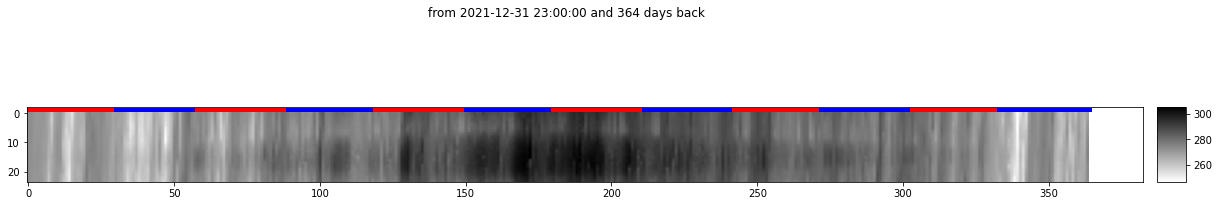

In [5]:
img(temp[21:])

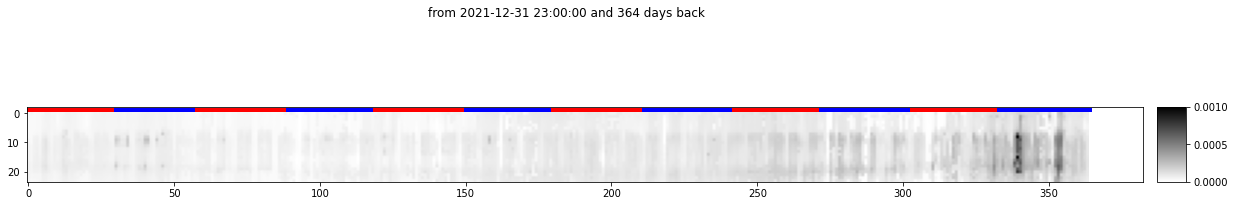

In [6]:
img(price[21:])

In [7]:
temp

,temp
2021-01-01 03:00:00,273.45
2021-01-01 04:00:00,273.15
2021-01-01 05:00:00,273.05
2021-01-01 06:00:00,272.95
2021-01-01 07:00:00,272.85
...,...
2021-12-31 19:00:00,273.75
2021-12-31 20:00:00,273.95
2021-12-31 21:00:00,273.95
2021-12-31 22:00:00,273.95


In [8]:
moment = '07-31-2021 16:00:00'  #random moment month-day-... we forecast from
pastLags = 24*30*2 #trainData length
horizon = 24 #we want to forecast next 24 hours; this value is also used in feature engineering (shift in lagData function)

loadPastExtra = 24*7*4 #4months load past extra to fill features inside pastLags 
covariatePastExtra = 24
covariateFutureExtra = 24

load = eicdata[eicdata.index<moment][-(pastLags+loadPastExtra):] #historical load data

covariateIndex = pd.date_range(start=load.index[loadPastExtra-covariatePastExtra],
                                periods=(covariatePastExtra+pastLags+horizon+covariateFutureExtra),freq='H')
 
temp = temp[temp.index.isin(covariateIndex)]
price = price[price.index.isin(covariateIndex)]

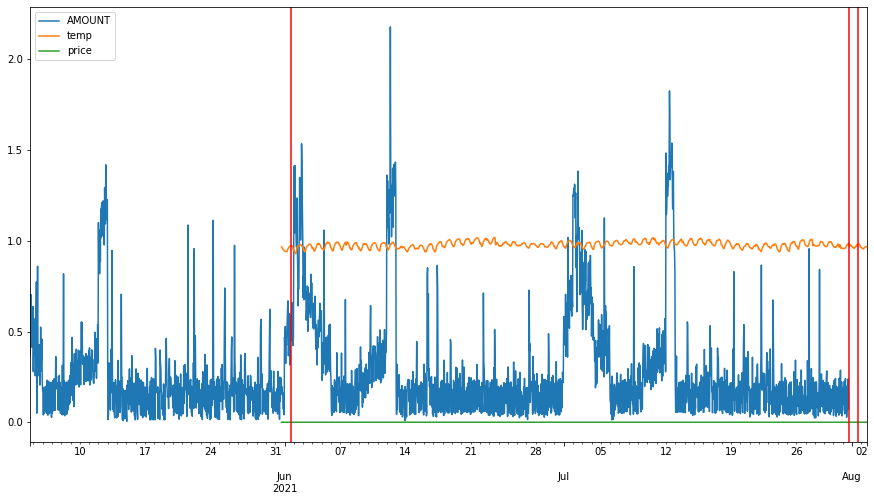

In [9]:
ax = load.plot(figsize=(15,8))
(temp/300).plot(ax=ax)
price.plot(ax=ax)
ax.axvline(moment,c='r') #moment of prediction
ax.axvline(pd.Timedelta(horizon-1, unit="h")+pd.to_datetime(moment),c='r') #last timestamp in test
ax.axvline(pd.Timedelta(-pastLags, unit="h")+pd.to_datetime(moment),c='r'); #first timestamp in trainVal
#note extras!!!

# feature engineering

In [10]:
#horizon and pastLags are needed here as parameters
datasets = dff.makeDatasets(load,temp,price,horizon,verbose=True)
joinedDataset = dff.joinFeatures(datasets,pastLags,horizon)

Lagged features prepatation time 0.146s
DateTime features prepatation time 0.032s
Temp features prepatation time 0.117s
Price features prepatation time 0.114s


In [11]:
print(f"trainVal features Nans {joinedDataset['trainValFeatures'].isna().sum().sum()}",
      f"\ntrainVal target Nans {joinedDataset['trainValTarget'].isna().sum().sum()}"
      f"\ntest features Nans {joinedDataset['testFeatures'].isna().sum().sum()}"
     )

trainVal features Nans 0 
trainVal target Nans 0
test features Nans 0


In [12]:
print(f"trainVal features number {len(joinedDataset['trainValFeatures'].columns)}",
      f"\ntrainVal target number {len(joinedDataset['trainValTarget'].columns)}"
      f"\ntest features number {len(joinedDataset['testFeatures'].columns)}"
     )

trainVal features number 229 
trainVal target number 1
test features number 229


# feature selection

In [13]:
#avalible methods:
methods = ['Sel','TSFresh','Cor','Freg','Uku','Kristjan']
#Sel: automatic based on autofeat library
#TSFresh: automatic based on tsfresh library
#Cor: automatic (with fixed hyperparameter) based on correlations
#Freg: autimatic (with fixed hyperparameter) based on f-regressor
#Uku: manual only 2 features temp and hour
#Kristjan: manual based on intuition

for m in methods:
    shortFeatureList = dff.shortenFeatures(joinedDataset['trainValFeatures'],joinedDataset['trainValTarget'],m)
    print(f'{m} features {len(shortFeatureList)}')

Sel features 15
TSFresh features 99
Cor features 30
Freg features 20
Uku features 2
Kristjan features 80


In [14]:
#use default selection method which is TSFresh
method='TSFresh'
shortFeatureList = dff.shortenFeatures(joinedDataset['trainValFeatures'],
                                       joinedDataset['trainValTarget'],
                                       #method='Sel'
                                      )

In [15]:
shortFeatureList

Index(['wday_1', 'wday_4', 'wday_5', 'y-1d', 'y-2d', 'y-7d', 'y-1w', 'y-2w',
       'y-4w', 'y-24-1', 'y-24-2', 'y-24-3', 'y-24-4', 'y-24-5', 'y-24-6',
       'y-24-7', 'y-24-8', 'y-24-9', 'y-24-10', 'y-24-11', 'y-24-12',
       'y-24-13', 'y-24-14', 'y-24-15', 'y-24-16', 'y-24-17', 'y-24-18',
       'y-24-19', 'y-24-20', 'y-24-21', 'y-24-22', 'y-24-23', 'y-24-24',
       'y-24_24hPmean', 'y-24_24hPstd', 'y-24_24hPmin', 'y-24_24hPmax',
       'y_7dPmean', 'y_7dPstd', 'y_7dPmin', 'y_5wd/2wePmean', 'y_5wd/2wePstd',
       'y_5wd/2wePmin', 'y_5wd/2wePmax', 'day', 'day_sin', 'day_cos',
       'dayofyear', 'dayofyear_sin', 'weekofyear', 'weekofyear_sin', 'weekday',
       'weekday_sin', 'weekday_cos', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12', 't-13', 't-14', 't-15', 't-16', 't-17', 't_24hPmean',
       't_24hPstd', 't_24hPmin', 't_24hPmax', 't_24hPminmax', 't_12hFmean',
       't_12hFstd', 't_12hFmin', 't_12hFmax', 't_12nh/12dhPmean',
       't_12nh/12dhPmin', 't_12n

In [16]:
trainValX = joinedDataset['trainValFeatures'][shortFeatureList]
trainValY = joinedDataset['trainValTarget']
testX = joinedDataset['testFeatures'][shortFeatureList]

# fit regressor

In [17]:
gb = dff.fixRegressor() #gradBoost regrossor with ranges of its hyperparameters

In [18]:
gb

{'regressor': sklearn.ensemble._gb.GradientBoostingRegressor,
 'hyperparams': {'n_estimators': array([ 50, 100, 150, 200]),
  'max_depth': array([4, 5, 6, 7, 8]),
  'learning_rate': array([0.1, 0.2]),
  'subsample': array([0.7, 0.8, 0.9, 1. ]),
  'random_state': [2022],
  'loss': ['absolute_error']}}

In [19]:
#validation options for random search cross validation:
#lastFold: validate on most recent trainVal data fold
#5folds: 5fold cross validation with ransomized samples
#expanding: expanding window cross validation
#rolling: rolling window cross validation

validate='expanding' #default value

#which estimator to choose based on cross validation
#bestVal='val': select estimator with lowest mean val error
#bestVal='topN': select estimator with lowest mean val error from topN list of less overfitting estimators 

bestVal='top3' #default value

#collect fitted regressor, scaler and fitting info
fitResults = dff.fitRegressor(regressor=gb,
                             trainValFeatures = trainValX,
                             trainValTarget = trainValY,
                             #validate='5folds',  #default is expanding
                             #bestVal='top1',  #defaut is top3
                             verbose=True
                             )

training time 36.809s


# diagnostics

In [20]:
print(f"top features {fitResults['top5Features']}",
      f"\nval mae {fitResults['scoreVal']:.3f}",
      f"\ntrain mae {fitResults['scoreTrain']:.3f}",
      f"\ntrainVal mae/R2/wmape {np.round(fitResults['scoreTrainVal'],3)}"
     )
#note overfitting by comparing train and val errors!

top features ['y-24-2', 'y_7dPmean', 'y-24-7', 'p+10', 'day'] 
val mae 0.193 
train mae 0.029 
trainVal mae/R2/wmape [0.042 0.911 0.148]


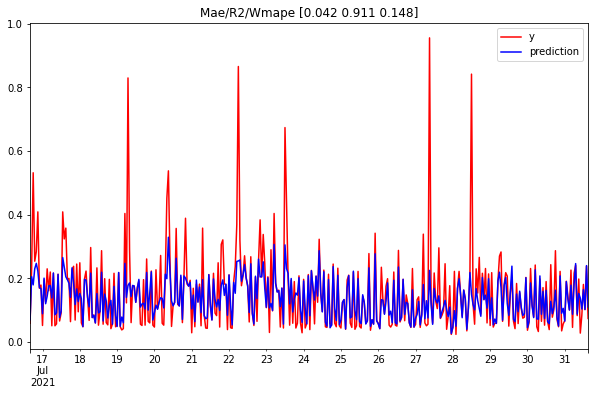

In [21]:
_ = dff.showPrediction(trainValX,fitResults,trainValY,mode='trainVal',verbose_img=True,n=24*15) #mode = trainVal or test

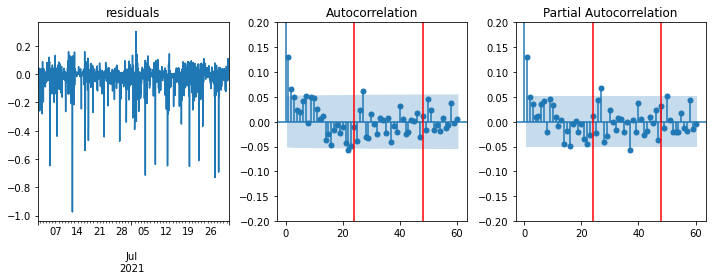

In [22]:
dff.showACF(trainValY,fitResults)

# predict

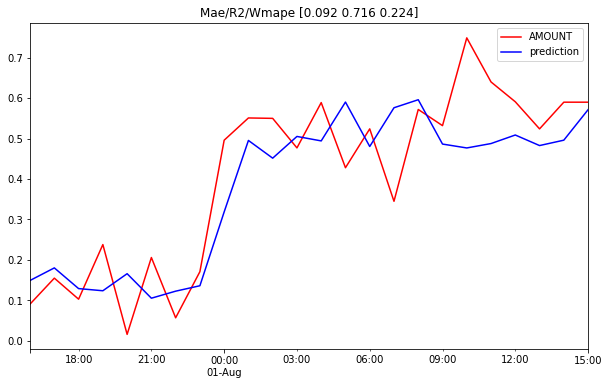

In [23]:
predictionResults = dff.showPrediction(testX,
                                       modelData=fitResults,
                                       verbose_img=True,
                                       mode='test',
                                       target=eicdata[eicdata.index>=moment][:horizon])

# save model

In [24]:
modelInfo = {}

modelInfo['initialParams'] = {
    'originOfPrediction': str(testX.index[0]),
    'predictionHorizon':horizon,
    'historicalDataLength':pastLags,
    'target/load':load,
    'target2predict':eicdata[eicdata.index>=moment][:horizon],
    'covariate/temperature':temp,
    'covariate/price':price
}

modelInfo['featureEngineering'] = {
    'engineeredFeaturesList':[i for i in datasets.keys()],
    'engineeredFeatures': joinedDataset['trainValFeatures'].columns.values
}

modelInfo['featureSelection'] = {
    'featureSelector':method,
    'selectedFeatures':shortFeatureList.values,
}

modelInfo['validation'] = {
    'cvScheme': validate,
    'validation': bestVal,
    'meanValMae': fitResults['scoreVal'],
    'meanTrainMae': fitResults['scoreTrain'],
    'cvResults': fitResults['cvResults']
}

modelInfo['fittedRegressor'] = {
    'fittedEstimator': fitResults['bestEstimator'],
    'fittedScaler': fitResults['bestScaler'],
    'estimatorHyperparams': fitResults['bestParams'],
    'top5Features': fitResults['top5Features']
}

modelInfo['diagnostics'] = {
    'trainValMae/R2/Wmape': fitResults['scoreTrainVal'],
    'predictionTrainVal': fitResults['predictionTrainVal']
}

In [25]:
pickle.dump(modelInfo, open('prediction_pipeline_model.pickle', "wb"))

In [26]:
modelInfo

{'initialParams': {'originOfPrediction': '2021-07-31 16:00:00',
  'predictionHorizon': 24,
  'historicalDataLength': 1440,
  'target/load':                      AMOUNT
  2021-05-04 16:00:00   0.365
  2021-05-04 17:00:00   0.573
  2021-05-04 18:00:00   0.703
  2021-05-04 19:00:00   0.620
  2021-05-04 20:00:00   0.414
  ...                     ...
  2021-07-31 11:00:00   0.085
  2021-07-31 12:00:00   0.181
  2021-07-31 13:00:00   0.102
  2021-07-31 14:00:00   0.239
  2021-07-31 15:00:00   0.074
  
  [2112 rows x 1 columns],
  'target2predict':                      AMOUNT
  2021-07-31 16:00:00   0.091
  2021-07-31 17:00:00   0.155
  2021-07-31 18:00:00   0.103
  2021-07-31 19:00:00   0.238
  2021-07-31 20:00:00   0.016
  2021-07-31 21:00:00   0.206
  2021-07-31 22:00:00   0.057
  2021-07-31 23:00:00   0.171
  2021-08-01 00:00:00   0.496
  2021-08-01 01:00:00   0.551
  2021-08-01 02:00:00   0.550
  2021-08-01 03:00:00   0.477
  2021-08-01 04:00:00   0.589
  2021-08-01 05:00:00   0.428
  20